# Setup

In [28]:
# Packages -----------------------------------------------#

# Data Analysis
import xarray as xr
import numpy as np
import pandas as pd
import metpy.calc as mpcalc
import matplotlib.dates as dates

# Plotting
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib.patches import Rectangle
from scipy.ndimage import gaussian_filter
from matplotlib.lines import Line2D

# Timing Processes
import time

# make sure the figures plot inline rather than at the end
%matplotlib inline

# get data from tigress
path = '../data/CHL/'
infn = 'all_L3m_19970901-20180831__GLOB_25_AVW-MODVIR_CHL1_MO_00_processed.nc'

ds_CHL = xr.open_dataset(path + infn)
ds_CHL

<xarray.Dataset>
Dimensions:                (lat: 200, lat_1deg: 50, lat_2deg: 25, lon: 340, lon_1deg: 85, lon_2deg: 43, month: 12, month_time: 252, season: 4, season_time: 84, time: 252)
Coordinates:
  * season_time            (season_time) datetime64[ns] 1997-09-01 ... 2018-06-01
  * lon                    (lon) float64 35.12 35.38 35.62 ... 119.4 119.6 119.9
  * lat                    (lat) float64 -19.88 -19.62 -19.38 ... 29.62 29.88
  * time                   (time) datetime64[ns] 1997-09-15 ... 2018-08-15
  * month_time             (month_time) datetime64[ns] 1997-09-01 ... 2018-08-01
  * lat_2deg               (lat_2deg) float64 -20.0 -18.0 -16.0 ... 26.0 28.0
  * lon_2deg               (lon_2deg) float64 35.0 37.0 39.0 ... 117.0 119.0
  * lat_1deg               (lat_1deg) float64 -20.0 -19.0 -18.0 ... 28.0 29.0
  * lon_1deg               (lon_1deg) float64 35.0 36.0 37.0 ... 118.0 119.0
  * month                  (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
  * season              

In [23]:
# Subset ------------------------------------------------#
# Create slice variables to subset domain before finding means
lat_slice = slice(-20, 30) # bounds inclusive
lon_slice = slice(40, 100) # bounds inclusive

# Get data, selecting lat/lon slice
# daily_chl = ds_CHL['daily_chl_2deg'].sel(lat=lat_slice,lon=lon_slice)
# daily_chl = daily_chl - np.nanmean(daily_chl,0)
mon_chl = ds_CHL['mon_chl_1deg'].sel(lat_1deg=lat_slice,lon_1deg=lon_slice)
mon_chl_mon_anom = ds_CHL['mon_chl_mon_anom_1deg'].sel(lat_1deg=lat_slice,lon_1deg=lon_slice)
chl_mon_clim = ds_CHL['chl_mon_clim_1deg'].sel(lat_1deg=lat_slice,lon_1deg=lon_slice)
lat = mon_chl_mon_anom.lat_1deg.values
lon = mon_chl_mon_anom.lon_1deg.values

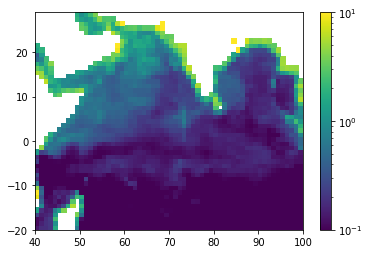

In [36]:
plt.pcolor(lon,lat,mon_chl[100,:,:],norm=colors.LogNorm(vmin=0.1, vmax=10))
plt.colorbar()


# Find Coastlines

In [8]:
# # ------------------------------------------------------------#
# # block out a few places that you don't want to include
# # ------------------------------------------------------------#

# mask = chl_mon_clim[0,:,:]
# xx,yy = np.meshgrid(lon,lat)

# # set Gulfs to Nans
# mask = mask.where(~((yy>22) & (xx<59)))
# mask = mask.where(~((yy>10) & (xx<51)))

# # AS inlets
# mask = mask.where(~((yy>21.5) & (yy<23) & (xx>72) & (xx<73)))
# mask = mask.where(~((yy>22.25) & (yy<23) & (xx>69) & (xx<70.5)))
# mask = mask.where(~((yy>23.25) & (yy<24) & (xx>68.5) & (xx<70)))

# # sri lanka are
# mask = mask.where(~((yy>8) & (yy<11) & (xx>77) & (xx<80)))

# # Sumatra area
# mask = mask.where(~((yy>4.5) & (yy<5.5) & (xx>95.5) & (xx<100)))
# # mask = mask.where(~((yy>3) & (yy<5.5) & (xx>97.5) & (xx<100)))
# mask = mask.where(~((yy>0) & (yy<10) & (xx>99) & (xx<100)))
# # mask = mask.where(~((yy>-1) & (yy<2.5) & (xx>90) & (xx<100)),1)
# # mask = mask.where(~((xx>98) & (yy<12)& (yy>6)))

# # # land
# mask = mask.where(~((yy>22) &(xx>74)))
# mask = mask.where(~((yy>12) & (yy<18) & (xx>75) & (xx<79)))
# mask = mask.where(~((yy>19) & (yy<24) & (xx>80) & (xx<85)))
# mask = mask.where(~((yy>24) & (xx>68)& (xx<70)))
# mask = mask.where(~((yy>24.5) & (xx>67)& (xx<70)))
# mask = mask.where(~((yy>-1) & (yy<5) & (xx>95) & (xx<100)),1)
# mask = mask.where(~((yy>-1) & (yy<7) & (xx>79) & (xx<100)),1)

# # equator
# # mask = mask.where(~(yy<0))
# # ------------------------------------------------------------#
# # locate points along the BoB and AS
# # ------------------------------------------------------------#

# def find_coast(arr):
#     import itertools
    
#     # create empty lists to add row and col info to
#     rowind = []
#     colind = []

#     # create an array of indices
#     rows = np.arange(arr.shape[0])
#     cols = np.arange(arr.shape[1])

#     # find if the sum of a block around a point is a nan (meaning one of the values at least must have been a nan)
#     for row,col in itertools.product(rows,cols):
# #         cond = (~np.isnan(arr[row,col])) & (np.isnan(np.sum(arr[max(0,row-1):min(arr.shape[0],row+2),max(0,col-1):min(arr.shape[1],col+2)])))
#         rowcond = (np.isnan(np.sum(arr[max(0,row-1):min(arr.shape[0],row+2),col])))
#         colcond = (np.isnan(np.sum(arr[row,max(0,col-1):min(arr.shape[1],col+2)])))

# #         if  (~np.isnan(arr[row,col])) & cond):
#         if  (~np.isnan(arr[row,col])) & (rowcond | colcond):
#             rowind.append(rows[row].tolist())
#             colind.append(cols[col].tolist())
    
#     return np.array(rowind), np.array(colind)

# sta_latinds_unord, sta_loninds_unord = find_coast(np.array(mask))
# # ------------------------------------------------------------#
# # Remove Manually some other points
# # ------------------------------------------------------------#

# # AS
# lons_from_sta = lon[sta_loninds_unord]
# lats_from_sta = lat[sta_latinds_unord]

# ind = ~((lons_from_sta <52) & (lats_from_sta < 25))
# sta_latinds_unord = sta_latinds_unord[ind]
# sta_loninds_unord = sta_loninds_unord[ind]

# #BoB
# lons_from_sta = np.array(lon[sta_loninds_unord])
# lats_from_sta = np.array(lat[sta_latinds_unord])

# ind =  ~((lons_from_sta >99))
# sta_latinds_unord = sta_latinds_unord[ind]
# sta_loninds_unord = sta_loninds_unord[ind]

# sta_latinds_unord = sta_latinds_unord[1:]
# sta_loninds_unord = sta_loninds_unord[1:]

# # ind =  ~((lons_from_sta <97) & (lons_from_sta > 85) & (lats_from_sta < 18) & (lats_from_sta > 1) )
# # sta_latinds_unord = sta_latinds_unord[ind]
# # sta_loninds_unord = sta_loninds_unord[ind]

# # ------------------------------------------------------------#
# # Plot
# # ------------------------------------------------------------#

# bounds = [40,100,-5,30]

# def add_land(ax,bounds):
#     res = '50m'
#     from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
#     land = cfeature.NaturalEarthFeature('physical', 'land', res,
#                                         edgecolor='face',
#                                         facecolor=cfeature.COLORS['land'])
#     ax.add_feature(land,color='gray',zorder = 0)
#     ax.background_patch.set_facecolor('k')
#     ax.coastlines(resolution=res,zorder = 0)
#     g = ax.gridlines(draw_labels=True,alpha=0)
#     g.xlabels_top = False
#     g.ylabels_right = False
#     g.xlabel_style = {'size': 15}
#     g.ylabel_style = {'size': 15}
#     g.xformatter = LONGITUDE_FORMATTER
#     g.yformatter = LATITUDE_FORMATTER
#     ax.axes.axis('tight')
#     ax.set_extent(bounds, crs=ccrs.PlateCarree())
    
# cmin = -0.2
# cmax = 0.2
# levels = np.linspace(cmin, cmax, 10)

# # Start figure
# fig = plt.figure(figsize=(16, 8))
# ax = plt.axes(projection=ccrs.PlateCarree())
# add_land(ax,bounds)
# plt.scatter(lon[sta_loninds_unord],lat[sta_latinds_unord],
#             s = 160,c=np.arange(len(sta_latinds_unord)),marker = '.',cmap =plt.cm.PiYG)
# plt.scatter(lon[sta_loninds_unord[16]],lat[sta_latinds_unord[16]],
#             s = 160,c='darkblue',marker = '.')
# plt.colorbar(label = 'Station No.')
# plt.title('Unordered Stations')

In [ ]:
# # ------------------------------------------------------------#
# # put in the right order
# # ------------------------------------------------------------#


# def order_coast(loninds,latinds,sta_zero):
#     # find based on radius
#     zipped_lists = zip(loninds, latinds)
#     sorted_pairs = sorted(zipped_lists, reverse=True)

#     # sort by lon
#     tuples = zip(*sorted_pairs)
#     lon_list,lat_list  = [ list(tuple) for tuple in  tuples]

#     pos = []
#     curr_sta = []
#     rem_sta = sorted_pairs
#     for i in range(len(lon_list)):
# #         print(i)
#         if i == 0:
#             curr_sta.append(sta_zero)
#             rem_sta.remove(sta_zero) 
#             prev_sta = sta_zero
#         else:
#             prev_sta = curr_sta[i-1]

#         start_len = len(curr_sta)
#         for j,(lo, la) in enumerate(rem_sta):
#             next_sta = (rem_sta[j])
            
#             diff = tuple(map(lambda l, k: l - k, curr_sta[i], next_sta))
            
#             # check uplr first
#             if(next_sta != prev_sta) & (all(np.abs(diff) == [0,1])) | (all(np.abs(diff) == [1,0])):
#                 curr_sta.append(next_sta)
#                 rem_sta.remove(next_sta) 
#                 break

#             # then check diagonals
#             elif (next_sta != prev_sta) & (all(np.abs(diff) == [1,1])):
#                 curr_sta.append(next_sta)
#                 rem_sta.remove(next_sta) 
#                 break
                
#         if len(curr_sta) == start_len:
#             print('No Next Station Found. Returning Previous Stations Only.')
#             print(curr_sta[i],rem_sta)
#             break
        
#     sta_lonind, sta_latind  = map(np.array, zip(*curr_sta))
    
#     return sta_lonind, sta_latind

# #initial station
# sta_zero = (sta_loninds_unord[16],sta_latinds_unord[16]) # 98.625, 10.375

# #calculate
# sta_loninds, sta_latinds =order_coast(sta_loninds_unord,sta_latinds_unord,sta_zero)

# # ------------------------------------------------------------#
# # identify first stations for EQ, BOB, and AS
# # ------------------------------------------------------------#

# sBoB = 0
# SL = 34
# mAS = 78
# loc_list = [sBoB,SL,mAS]
# # 
# # ------------------------------------------------------------#
# # plot
# # ------------------------------------------------------------#
# bounds = [40,100,-5,30]

# def add_land(ax,bounds):
#     res = '50m'
#     from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
#     land = cfeature.NaturalEarthFeature('physical', 'land', res,
#                                         edgecolor='face',
#                                         facecolor=cfeature.COLORS['land'])
#     ax.add_feature(land,color='gray',zorder = 0)
#     ax.background_patch.set_facecolor('k')
#     ax.coastlines(resolution=res,zorder = 0)
#     g = ax.gridlines(draw_labels=True,alpha=0)
#     g.xlabels_top = False
#     g.ylabels_right = False
#     g.xlabel_style = {'size': 15}
#     g.ylabel_style = {'size': 15}
#     g.xformatter = LONGITUDE_FORMATTER
#     g.yformatter = LATITUDE_FORMATTER
#     ax.axes.axis('tight')
#     ax.set_extent(bounds, crs=ccrs.PlateCarree())
    
# cmin = -0.2
# cmax = 0.2
# levels = np.linspace(cmin, cmax, 10)

# # Start figure
# fig = plt.figure(figsize=(16, 8))
# ax = plt.axes(projection=ccrs.PlateCarree())
# add_land(ax,bounds)
# # cf = ax.contourf(lon, lat,sla_mon_anom[0,:,:],levels = levels,cmap=plt.cm.PuOr_r, extend="both")
# # xx,yy = np.meshgrid(lon,lat)
# # plt.scatter(xx.flatten(),yy.flatten(),s = 160,c='w',marker = '.')
# p =plt.scatter(lon[sta_loninds],lat[sta_latinds],
#             s = 160,c=np.arange(len(sta_latinds)),marker = '.',cmap =plt.cm.PiYG) 
# plt.scatter(lon[sta_loninds[loc_list]],lat[sta_latinds[loc_list]],
#             s = 260,c='darkblue',marker = '.')
# plt.colorbar(p,label = 'Station No.')
# plt.title('Ordered Stations')

# plt.savefig('../figures/stations-CHL-along-coast.png', dpi=300, bbox_inches='tight')

Text(0.5, 1.0, 'Ordered Stations')

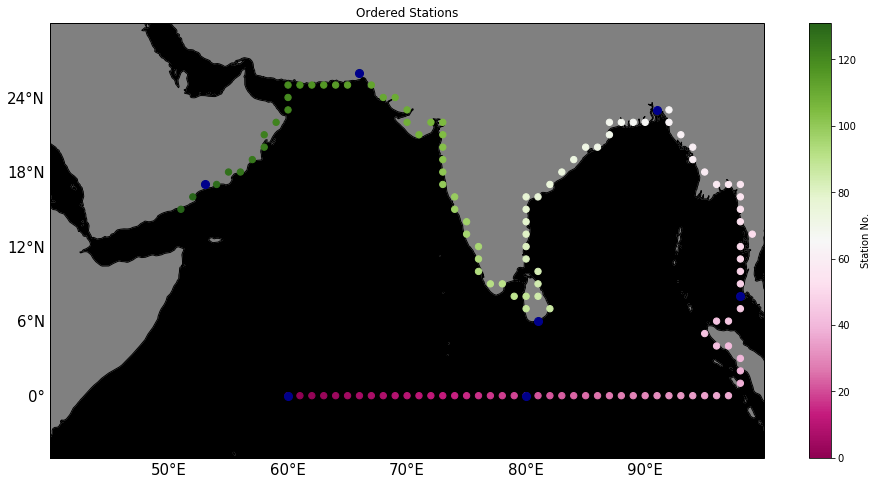

In [37]:
# load data
ds_CL= xr.open_dataset('../data/SLA/SLA-1-degree-coastlines.nc')

# ------------------------------------------------------------#
# plot
# ------------------------------------------------------------#
cbounds = [40,100,-5,30]

def add_land(ax,bounds):
    res = '50m'
    from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
    land = cfeature.NaturalEarthFeature('physical', 'land', res,
                                        edgecolor='face',
                                        facecolor=cfeature.COLORS['land'])
    ax.add_feature(land,color='gray',zorder = 0)
    ax.background_patch.set_facecolor('k')
    ax.coastlines(resolution=res,zorder = 0)
    g = ax.gridlines(draw_labels=True,alpha=0)
    g.xlabels_top = False
    g.ylabels_right = False
    g.xlabel_style = {'size': 15}
    g.ylabel_style = {'size': 15}
    g.xformatter = LONGITUDE_FORMATTER
    g.yformatter = LATITUDE_FORMATTER
    ax.axes.axis('tight')
    ax.set_extent(bounds, crs=ccrs.PlateCarree())
    
cmin = -0.2
cmax = 0.2
levels = np.linspace(cmin, cmax, 10)

# Start figure
fig = plt.figure(figsize=(16, 8))
ax = plt.axes(projection=ccrs.PlateCarree())
add_land(ax,cbounds)
p =plt.scatter(lon[ds_CL.sta_loninds],lat[ds_CL.sta_latinds],
            s = 160,c=np.arange(len(ds_CL.sta_latinds)),marker = '.',cmap =plt.cm.PiYG) 
plt.scatter(lon[np.array(ds_CL.sta_loninds[ds_CL.loc_list])],
            lat[np.array(ds_CL.sta_latinds[ds_CL.loc_list])],
            s = 260,c='darkblue',marker = '.')
plt.colorbar(p,label = 'Station No.')
plt.title('Ordered Stations')

# plt.savefig('../figures/stations-CHL-along-coast.png', dpi=300, bbox_inches='tight')

# Group Anomalies Into IOD Phases

In [50]:
# load DMI data
ds_DMI= xr.open_dataset('../data/DMI/dmi_processed.nc')
ds_DMI

# posIODyears = list(np.array(ds_DMI.pos_IOD_years[ds_DMI.pos_IOD_years >= 1994]))
posIODyears = [1997]
negIODyears = list(np.array(ds_DMI.neg_IOD_years[ds_DMI.neg_IOD_years >= 1994]))
neuIODyears = list(np.array(ds_DMI.neu_IOD_years[ds_DMI.neu_IOD_years >= 1994]))

In [51]:
begin = '-06-01'
end = '-05-31'

# average over the positive IOD years -------------------------------------------# 
mon_data = []
# for ii,year in enumerate(list(np.array(ds_DMI.pos_IOD_years))):
for ii,year in enumerate(posIODyears):
    start_time = str(year) + begin
    end_time = str(year+1) + end
    time_slice = slice(start_time, end_time)
    mon_data.append(mon_chl_mon_anom.sel(month_time=time_slice))

# add all the data together
posIOD_mon_chl_mon_anom = xr.concat(mon_data, dim='month_time')
# take the mean for each month of all the years
posIOD_mon_chl_mon_anom = posIOD_mon_chl_mon_anom.groupby('month_time.month').mean(dim='month_time')
#start in march instead of 01
posIOD_mon_chl_mon_anom = posIOD_mon_chl_mon_anom.roll(month=-5,roll_coords = False)

# average over the negative IOD years -------------------------------------------# 
mon_data = []
# for ii,year in enumerate(list(np.array(ds_DMI.neg_IOD_years))):
for ii,year in enumerate(negIODyears):
    start_time = str(year) + begin
    end_time = str(year+1) + end
    time_slice = slice(start_time, end_time)
    mon_data.append(mon_chl_mon_anom.sel(month_time=time_slice))
    
negIOD_mon_chl_mon_anom = xr.concat(mon_data, dim='month_time')
negIOD_mon_chl_mon_anom = negIOD_mon_chl_mon_anom.groupby('month_time.month').mean(dim='month_time')
negIOD_mon_chl_mon_anom = negIOD_mon_chl_mon_anom.roll(month=-5,roll_coords = False)

# average over the neutral IOD years -------------------------------------------# 
mon_data = []
# for ii,year in enumerate(list(np.array(ds_DMI.neu_IOD_years))):
for ii,year in enumerate(neuIODyears):
    start_time = str(year) + begin
    end_time = str(year+1) + end
    time_slice = slice(start_time, end_time)
    mon_data.append(mon_chl_mon_anom.sel(month_time=time_slice))

neuIOD_mon_chl_mon_anom = xr.concat(mon_data, dim='month_time')
neuIOD_mon_chl_mon_anom = neuIOD_mon_chl_mon_anom.groupby('month_time.month').mean(dim='month_time')
neuIOD_mon_chl_mon_anom = neuIOD_mon_chl_mon_anom.roll(month=-5,roll_coords = False)

/home/jennap/anaconda3/lib/python3.7/site-packages/xarray/core/nanops.py:161: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


# Hovmueller Diagrams

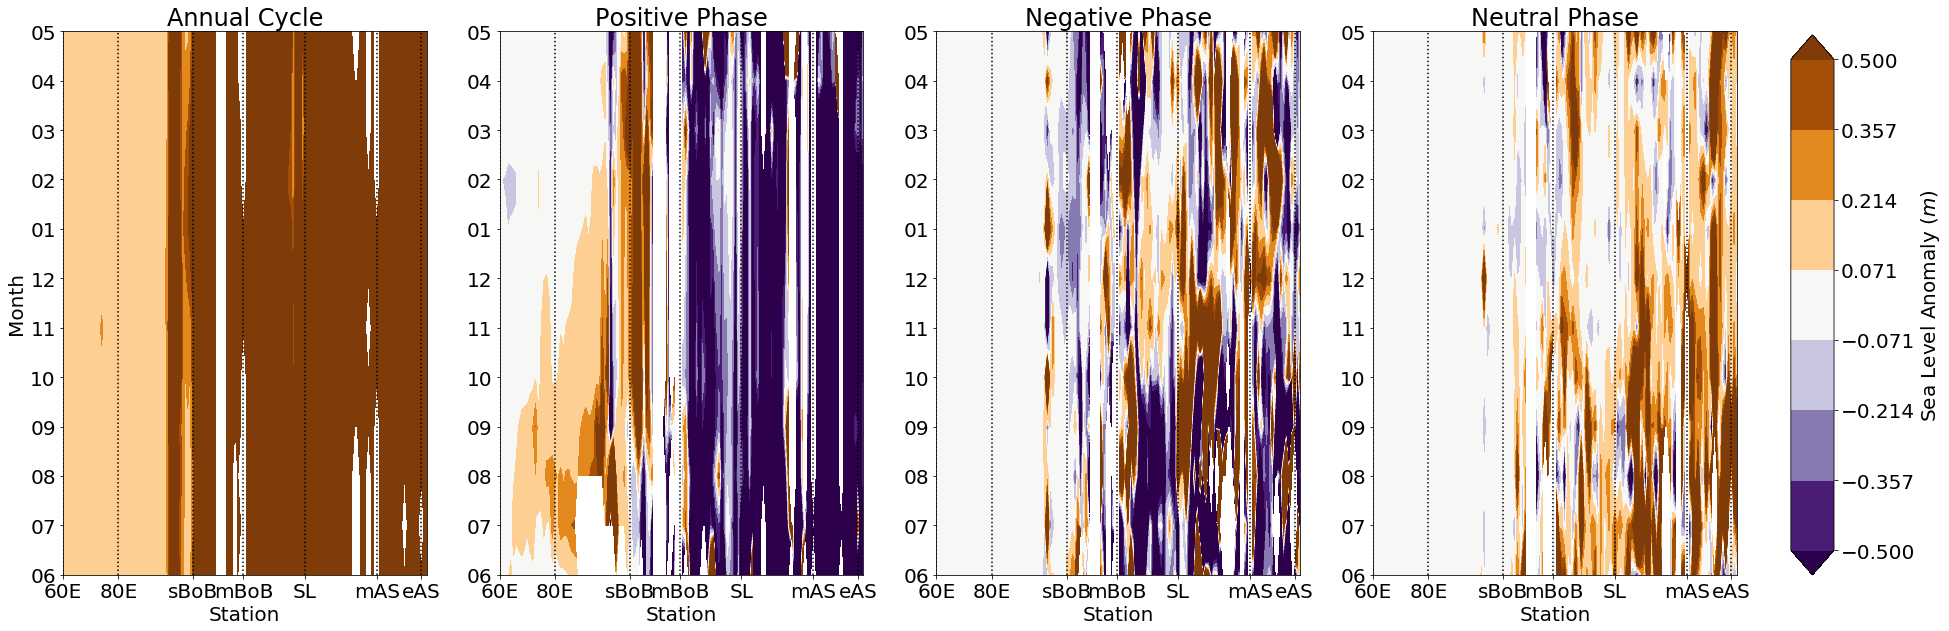

In [52]:
# create list of integer years
rolled_ann_cyc = chl_mon_clim.roll(month=-5,roll_coords = False)
IODphases = list([rolled_ann_cyc,posIOD_mon_chl_mon_anom,negIOD_mon_chl_mon_anom,neuIOD_mon_chl_mon_anom])
titles = ['Annual Cycle','Positive Phase','Negative Phase', 'Neutral Phase']
plt.rcParams.update({'font.size': 20})

cmin = -0.5
cmax = 0.5

fig = plt.figure(figsize=(30, 10))
for ii,phase in enumerate(IODphases):
    
    # Get times and make array of datetime objects
    vtimes = phase.month
    
    data = np.zeros([vtimes.shape[0],ds_CL.sta_loninds.shape[0]])*np.nan
#     print(data.shape)
    for jj in range(ds_CL.sta_loninds.shape[0]):
        data[:,jj] = phase[:,ds_CL.sta_latinds[jj],ds_CL.sta_loninds[jj]]

    # colorbar limits
    levels = np.linspace(cmin, cmax, 8)

    # Specify longitude values for chosen domain
    sta = np.arange(len(ds_CL.sta_loninds))

    ax = fig.add_subplot(1,4,ii+1)

    # Plot of chosen variable averaged over latitude and slightly smoothed
    cf = ax.contourf(sta,vtimes,data,levels = levels,cmap=plt.cm.PuOr_r, extend="both")
    for loc in ds_CL.loc_list:
        plt.axvline(x=loc,color = 'k',linestyle = ':')
        
    plt.xlabel('Station')
    if ii == 0:
        plt.ylabel('Month')
    
    plt.title(titles[ii])
    ax.set_yticklabels(['06','07','08','09','10','11','12','01','02','03', '04', '05'])
    ax.set_xticks(ds_CL.loc_list)
#     ax.set_xticklabels(['sBoB','SL','eAS'])
    ax.set_xticklabels(['60E','80E', 'sBoB','mBoB', 'SL', 'mAS','eAS'])
    ax.set_yticks(list(np.arange(1,13)))
    cf.set_clim(cmin, cmax)# reset lims because contourf does weird things.

cbar_ax = fig.add_axes([0.925, 0.125, 0.02, 0.75])
cbar = fig.colorbar(cf,cax=cbar_ax, pad=0.04)
cbar.set_label('Sea Level Anomaly ($m$)')

# plt.savefig('../figures/seasonal-and-IOD-years-CHL-along-coast-4km.png', dpi=300, bbox_inches='tight')



In [ ]:
# singular plots 
# create list of integer years
rolled_ann_cyc = sla_mon_clim_dtrnd.roll(month=-5,roll_coords = False)
IODphases = list([rolled_ann_cyc,posIOD_mon_sla_mon_anom_dtrnd,negIOD_mon_sla_mon_anom_dtrnd,neuIOD_mon_sla_mon_anom_dtrnd])
titles = ['Annual Cycle','Positive Phase','Negative Phase', 'Neutral Phase']
titles_save = ['annual-cycle','positive-phase','negative-phase', 'neutral-phase']
plt.rcParams.update({'font.size': 20})

cmin = -0.15
cmax = 0.15

for ii,phase in enumerate(IODphases):
    
    fig = plt.figure(figsize=(14, 18))
    
    # Get times and make array of datetime objects
    vtimes = phase.month
    
    data = np.zeros([vtimes.shape[0],sta_loninds.shape[0]])
#     print(data.shape)
    for jj in range(sta_loninds.shape[0]):
        data[:,jj] = phase[:,sta_latinds[jj],sta_loninds[jj]]

    # colorbar limits
    levels = np.linspace(cmin, cmax, 10)

    # Specify longitude values for chosen domain
    sta = np.arange(len(sta_loninds))

    ax = fig.add_subplot(1,1,1)

    # Plot of chosen variable averaged over latitude and slightly smoothed
    cf = ax.contourf(sta,vtimes,data,levels = levels,cmap=plt.cm.PuOr_r, extend="both")
    for loc in loc_list:
        plt.axvline(x=loc,color = 'k',linestyle = ':')
        
    plt.xlabel('Station')
    if ii == 0:
        plt.ylabel('Month')
    
    plt.title(titles[ii])
    ax.set_yticklabels(['06','07','08','09','10','11','12','01','02','03', '04', '05'])
    ax.set_xticks(loc_list)
    ax.set_xticklabels(['60E','80E', 'sBoB','mBoB', 'SL', 'mAS','eAS'])
    ax.set_yticks(list(np.arange(1,13)))
    cf.set_clim(cmin, cmax)# reset lims because contourf does weird things.

    cbar_ax = fig.add_axes([0.925, 0.125, 0.02, 0.75])
    cbar = fig.colorbar(cf,cax=cbar_ax, pad=0.04)
    cbar.set_label('Interannual Sea Level Anomaly ($m$)')
    plt.savefig('../figures/' + titles_save[ii] +'-SLA-along-coast.png', dpi=300, bbox_inches='tight')




# Enhance/supress Seasonal Cycle

In [ ]:
# create list of integer years
rolled_ann_cyc = sla_mon_clim_dtrnd.roll(month=-5,roll_coords = False)
IODphases = list([posIOD_mon_sla_mon_anom_dtrnd,negIOD_mon_sla_mon_anom_dtrnd,neuIOD_mon_sla_mon_anom_dtrnd])
titles = ['Positive Phase','Negative Phase', 'Neutral Phase']
plt.rcParams.update({'font.size': 20})

cmin = -500
cmax = 500

fig = plt.figure(figsize=(30, 10))
for ii,phase in enumerate(IODphases):
    percent = abs((rolled_ann_cyc-phase)/rolled_ann_cyc)*100
    var = np.sign(rolled_ann_cyc) * np.sign(phase)*percent
    
    # Get times and make array of datetime objects
    vtimes = phase.month
    
    data = np.zeros([vtimes.shape[0],sta_loninds.shape[0]])
    ann_cyc_data = np.zeros([vtimes.shape[0],sta_loninds.shape[0]])
    
#     print(data.shape)
    for jj in range(sta_loninds.shape[0]):
        data[:,jj] = var[:,sta_latinds[jj],sta_loninds[jj]]
        ann_cyc_data = rolled_ann_cyc[:,sta_latinds[jj],sta_loninds[jj]]

    # colorbar limits
    levels = np.linspace(cmin, cmax, 50)

    # Specify longitude values for chosen domain
    sta = np.arange(len(sta_loninds))

#     if ii == 1:
        
#         ax = fig.add_subplot(1,4,ii+1)

#         # Plot of chosen variable averaged over latitude and slightly smoothed
#         cf = ax.contourf(sta,vtimes,ann_cyc_data,levels = levels,cmap=plt.cm.PuOr_r, extend="both")
#         for loc in loc_list:
#             plt.axvline(x=loc,color = 'k',linestyle = ':')

#         plt.xlabel('Station')
#         if ii == 0:
#             plt.ylabel('Month')

#         plt.title(titles[ii])
#         ax.set_yticklabels(['06','07','08','09','10','11','12','01','02','03', '04', '05'])
#         ax.set_xticks(loc_list)
#         ax.set_xticklabels(['60E','80E', 'sBoB','mBoB', 'SL', 'mAS','eAS'])
#         ax.set_yticks(list(np.arange(1,13)))
#         cf.set_clim(cmin, cmax)# reset lims because contourf does weird things.
        
#         ax = fig.add_subplot(1,4,ii+1)

#         # Plot of chosen variable averaged over latitude and slightly smoothed
#         cf = ax.contourf(sta,vtimes,data,levels = levels,cmap=plt.cm.PuOr_r, extend="both")
#         for loc in loc_list:
#             plt.axvline(x=loc,color = 'k',linestyle = ':')

#         plt.xlabel('Station')
#         if ii == 0:
#             plt.ylabel('Month')

#         plt.title(titles[ii])
#         ax.set_yticklabels(['06','07','08','09','10','11','12','01','02','03', '04', '05'])
#         ax.set_xticks(loc_list)
#         ax.set_xticklabels(['60E','80E', 'sBoB','mBoB', 'SL', 'mAS','eAS'])
#         ax.set_yticks(list(np.arange(1,13)))
#         cf.set_clim(cmin, cmax)# reset lims because contourf does weird things.
#     else:
    ax = fig.add_subplot(1,3,ii+1)

    # Plot of chosen variable averaged over latitude and slightly smoothed
    cf = ax.contourf(sta,vtimes,data,levels = levels,cmap=plt.cm.PuOr_r, extend="both")
    for loc in loc_list:
        plt.axvline(x=loc,color = 'k',linestyle = ':')

    plt.xlabel('Station')
    if ii == 0:
        plt.ylabel('Month')

    plt.title(titles[ii])
    ax.set_yticklabels(['06','07','08','09','10','11','12','01','02','03', '04', '05'])
    ax.set_xticks(loc_list)
    ax.set_xticklabels(['60E','80E', 'sBoB','mBoB', 'SL', 'mAS','eAS'])
    ax.set_yticks(list(np.arange(1,13)))
    cf.set_clim(cmin, cmax)# reset lims because contourf does weird things.

cbar_ax = fig.add_axes([0.925, 0.125, 0.02, 0.75])
cbar = fig.colorbar(cf,cax=cbar_ax, pad=0.04)
cbar.set_label('Interannual Sea Level Anomaly ($m$)')

# plt.savefig('../figures/seasonal-and-IOD-years-SLA-along-coast-0-25-degree.png', dpi=300, bbox_inches='tight')




In [ ]:
# create list of integer years
rolled_ann_cyc = sla_mon_clim_dtrnd.roll(month=-5,roll_coords = False)
IODphases = list([rolled_ann_cyc,posIOD_mon_sla_mon_anom_dtrnd,negIOD_mon_sla_mon_anom_dtrnd])
titles = ['Annual Cycle','Positive Phase + AC','Negative Phase + AC', 'Neutral Phase + AC']
plt.rcParams.update({'font.size': 20})

cmin = -0.3
cmax = 0.3

fig = plt.figure(figsize=(30, 12))
for ii,phase in enumerate(IODphases):
    
    if ii == 0:
        var = rolled_ann_cyc
    else:
        var = rolled_ann_cyc + phase
    
    # Get times and make array of datetime objects
    vtimes = phase.month
    
    data = np.zeros([vtimes.shape[0],sta_loninds.shape[0]])
#     print(data.shape)
    for jj in range(sta_loninds.shape[0]):
        data[:,jj] = var[:,sta_latinds[jj],sta_loninds[jj]]

    # colorbar limits
    levels = np.linspace(cmin, cmax, 10)

    # Specify longitude values for chosen domain
    sta = np.arange(len(sta_loninds))

    ax = fig.add_subplot(1,3,ii+1)

    # Plot of chosen variable averaged over latitude and slightly smoothed
    cf = ax.contourf(sta,vtimes,data,levels = levels,cmap=plt.cm.PuOr_r, extend="both")
    for loc in loc_list:
        plt.axvline(x=loc,color = 'k',linestyle = ':')
        
    plt.xlabel('Station')
    if ii == 0:
        plt.ylabel('Month')
    
    plt.title(titles[ii])
    ax.set_yticklabels(['06','07','08','09','10','11','12','01','02','03', '04', '05'])
    ax.set_xticks(loc_list)
    ax.set_xticklabels(['60E','80E', 'sBoB','mBoB', 'SL', 'mAS','eAS'])
    ax.set_yticks(list(np.arange(1,13)))
    cf.set_clim(cmin, cmax)# reset lims because contourf does weird things.

cbar_ax = fig.add_axes([0.925, 0.125, 0.02, 0.75])
cbar = fig.colorbar(cf,cax=cbar_ax, pad=0.04)
cbar.set_label('Sea Level Anomaly ($m$)')

plt.savefig('../figures/seasonal-and-IOD-years-add-SLA-along-coast-0-25-degree.png', dpi=200, bbox_inches='tight')




In [ ]:
rolled_ann_cyc

# Weak and Strong IOD Event

In [ ]:
sposIODyears = [1994,1997,2006,2019]
wposIODyears = [2012, 2015, 2018]

# average over the strong positive IOD years -------------------------------------------# 
daily_data = []
mon_data = []
mon_clim = []
# for ii,year in enumerate(list(np.array(ds_DMI.pos_IOD_years))):
for ii,year in enumerate(sposIODyears):
    start_time = str(year) + '-06-01'
    end_time = str(year+1) + '-05-31'
    time_slice = slice(start_time, end_time)
    mon_data.append(mon_sla_mon_anom_dtrnd.sel(month_time=time_slice))

# add all the data together
sposIOD_mon_sla_mon_anom_dtrnd = xr.concat(mon_data, dim='month_time')
# take the mean for each month of all the years
sposIOD_mon_sla_mon_anom_dtrnd = sposIOD_mon_sla_mon_anom_dtrnd.groupby('month_time.month').mean(dim='month_time')
#start in march instead of 01
sposIOD_mon_sla_mon_anom_dtrnd = sposIOD_mon_sla_mon_anom_dtrnd.roll(month=-5,roll_coords = False)

# average over the weak positive IOD years -------------------------------------------# 
daily_data = []
mon_data = []
mon_clim = []
# for ii,year in enumerate(list(np.array(ds_DMI.pos_IOD_years))):
for ii,year in enumerate(wposIODyears):
    start_time = str(year) + '-06-01'
    end_time = str(year+1) + '-05-31'
    time_slice = slice(start_time, end_time)
    mon_data.append(mon_sla_mon_anom_dtrnd.sel(month_time=time_slice))

# add all the data together
wposIOD_mon_sla_mon_anom_dtrnd = xr.concat(mon_data, dim='month_time')
# take the mean for each month of all the years
wposIOD_mon_sla_mon_anom_dtrnd = wposIOD_mon_sla_mon_anom_dtrnd.groupby('month_time.month').mean(dim='month_time')
#start in march instead of 01
wposIOD_mon_sla_mon_anom_dtrnd = wposIOD_mon_sla_mon_anom_dtrnd.roll(month=-5,roll_coords = False)


snegIODyears = [1996]
wnegIODyears = [1996,1998,2016]


# average over the strong negative IOD years -------------------------------------------# 
daily_data = []
mon_data = []
mon_clim = []
# for ii,year in enumerate(list(np.array(ds_DMI.pos_IOD_years))):
for ii,year in enumerate(snegIODyears):
    start_time = str(year) + '-06-01'
    end_time = str(year+1) + '-05-31'
    time_slice = slice(start_time, end_time)
    mon_data.append(mon_sla_mon_anom_dtrnd.sel(month_time=time_slice))

# add all the data together
snegIOD_mon_sla_mon_anom_dtrnd = xr.concat(mon_data, dim='month_time')
# take the mean for each month of all the years
snegIOD_mon_sla_mon_anom_dtrnd = snegIOD_mon_sla_mon_anom_dtrnd.groupby('month_time.month').mean(dim='month_time')
#start in march instead of 01
snegIOD_mon_sla_mon_anom_dtrnd = snegIOD_mon_sla_mon_anom_dtrnd.roll(month=-5,roll_coords = False)

# average over the weak negative IOD years -------------------------------------------# 
daily_data = []
mon_data = []
mon_clim = []
# for ii,year in enumerate(list(np.array(ds_DMI.pos_IOD_years))):
for ii,year in enumerate(wnegIODyears):
    start_time = str(year) + '-06-01'
    end_time = str(year+1) + '-05-31'
    time_slice = slice(start_time, end_time)
    mon_data.append(mon_sla_mon_anom_dtrnd.sel(month_time=time_slice))

# add all the data together
wnegIOD_mon_sla_mon_anom_dtrnd = xr.concat(mon_data, dim='month_time')
# take the mean for each month of all the years
wnegIOD_mon_sla_mon_anom_dtrnd = wnegIOD_mon_sla_mon_anom_dtrnd.groupby('month_time.month').mean(dim='month_time')
#start in march instead of 01
wnegIOD_mon_sla_mon_anom_dtrnd = wnegIOD_mon_sla_mon_anom_dtrnd.roll(month=-5,roll_coords = False)

In [ ]:
# create list of integer years
IODphases = list([sposIOD_mon_sla_mon_anom_dtrnd,snegIOD_mon_sla_mon_anom_dtrnd,
                 wposIOD_mon_sla_mon_anom_dtrnd,wnegIOD_mon_sla_mon_anom_dtrnd])
titles = ['Strong Positive Phase',' Strong Negative Phase','Weak Positive Phase',' Weak Negative Phase']
plt.rcParams.update({'font.size': 20})

cmin = -0.15
cmax = 0.15

fig = plt.figure(figsize=(20, 20))
for ii,phase in enumerate(IODphases):
    
    # Get times and make array of datetime objects
    vtimes = phase.month
    
    data = np.zeros([vtimes.shape[0],sta_loninds.shape[0]])
#     print(data.shape)
    for jj in range(sta_loninds.shape[0]):
        data[:,jj] = phase[:,sta_latinds[jj],sta_loninds[jj]]

    # colorbar limits
    levels = np.linspace(cmin, cmax, 10)

    # Specify longitude values for chosen domain
    sta = np.arange(len(sta_loninds))

    ax = fig.add_subplot(2,2,ii+1)

    # Plot of chosen variable averaged over latitude and slightly smoothed
    cf = ax.contourf(sta,vtimes,data,levels = levels,cmap=plt.cm.PuOr_r, extend="both")
    for loc in loc_list:
        plt.axvline(x=loc,color = 'k',linestyle = ':')
        
    plt.xlabel('Station')
    if ii == 0:
        plt.ylabel('Month')
    
    plt.title(titles[ii])
    ax.set_yticklabels(['06','07','08','09','10','11','12','01','02','03', '04', '05'])
    ax.set_xticks(loc_list)
    ax.set_xticklabels(['60E','80E', 'sBoB','mBoB', 'SL', 'mAS','eAS'])
    ax.set_yticks(list(np.arange(1,13)))
    cf.set_clim(cmin, cmax)# reset lims because contourf does weird things.

cbar_ax = fig.add_axes([0.925, 0.125, 0.02, 0.75])
cbar = fig.colorbar(cf,cax=cbar_ax, pad=0.04)
cbar.set_label('Sea Level Anomaly ($m$)')

plt.savefig('../figures/strong-and-weak-IOD-years-SLA-along-coast.png', dpi=200, bbox_inches='tight')


In [ ]:
# create list of integer years
IODphases = list([rolled_ann_cyc,sposIOD_mon_sla_mon_anom_dtrnd,snegIOD_mon_sla_mon_anom_dtrnd])
titles = ['Annual Cycle','Strong Positive Phase + AC',' Strong Negative Phase + AC']
plt.rcParams.update({'font.size': 20})

cmin = -0.3
cmax = 0.3

fig = plt.figure(figsize=(30, 12))
for ii,phase in enumerate(IODphases):
    
    if ii == 0:
        var = rolled_ann_cyc
    else:
        var = rolled_ann_cyc + phase
        
    # Get times and make array of datetime objects
    vtimes = phase.month
    
    data = np.zeros([vtimes.shape[0],sta_loninds.shape[0]])
#     print(data.shape)
    for jj in range(sta_loninds.shape[0]):
        data[:,jj] = var[:,sta_latinds[jj],sta_loninds[jj]]

    # colorbar limits
    levels = np.linspace(cmin, cmax, 10)

    # Specify longitude values for chosen domain
    sta = np.arange(len(sta_loninds))

    ax = fig.add_subplot(1,3,ii+1)

    # Plot of chosen variable averaged over latitude and slightly smoothed
    cf = ax.contourf(sta,vtimes,data,levels = levels,cmap=plt.cm.PuOr_r, extend="both")
    for loc in loc_list:
        plt.axvline(x=loc,color = 'k',linestyle = ':')
        
    plt.xlabel('Station')
    if ii == 0:
        plt.ylabel('Month')
    
    plt.title(titles[ii])
    ax.set_yticklabels(['06','07','08','09','10','11','12','01','02','03', '04', '05'])
    ax.set_xticks(loc_list)
    ax.set_xticklabels(['60E','80E', 'sBoB','mBoB', 'SL', 'mAS','eAS'])
    ax.set_yticks(list(np.arange(1,13)))
    cf.set_clim(cmin, cmax)# reset lims because contourf does weird things.

cbar_ax = fig.add_axes([0.925, 0.125, 0.02, 0.75])
cbar = fig.colorbar(cf,cax=cbar_ax, pad=0.04)
cbar.set_label('Sea Level Anomaly ($m$)')

plt.savefig('../figures/strong-and-weak-IOD-years-add-SLA-along-coast.png', dpi=200, bbox_inches='tight')



# Seasonal Cycle

In [ ]:
ds_SLA.sla_seas_clim_dtrnd.season

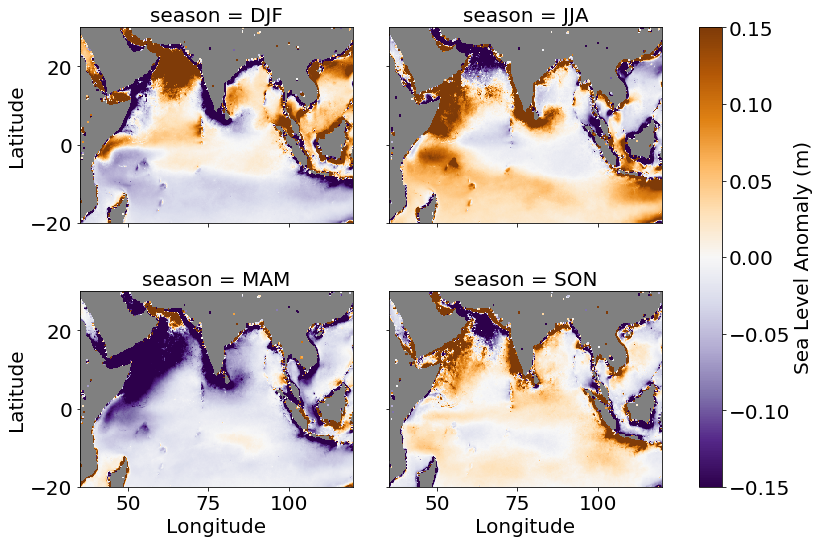

In [35]:
seasona = ['JJA','MAM','SON','DJF']

# rolled_seas_cycle = ds_CHL.chl_seas_clim.roll(season=-1,roll_coords = False)
p = ds_CHL.chl_seas_clim.plot.pcolormesh(x="lon", y="lat", col="season", col_wrap=2,
                                        cmap="PuOr_r",
                                        vmax=0.15,vmin=-0.15, # set colorbar lims
                                        extend = 'neither', # make a box colorbar rather than pointed
                                        figsize = (12, 8),
                                        cbar_kwargs={"label": "Sea Level Anomaly (m)"},
                                        subplot_kws={'facecolor': 'gray'}
                                       )

for i, ax in enumerate(p.axes.flat):
#     ax.set_title(months[i])
    ax.axes.axis('tight')
#     plt.subplots_adjust(top=.9)

p.set_xlabels('Longitude')
p.set_ylabels('Latitude')
plt.savefig('../figures/seasonal-cycle-SLA.png', dpi=300, bbox_inches='tight')

In [37]:
rolled_ann_cyc

<xarray.DataArray 'chl_mon_clim_1deg' (month: 12, lat_1deg: 50, lon_1deg: 61)>
array([[[ 2.472640e-02,  1.946199e-02, ...,  5.783426e-03,  7.499543e-03],
        [ 2.237476e-02,  2.026848e-02, ...,  6.320180e-03,  8.313027e-03],
        ...,
        [          nan,           nan, ...,           nan,           nan],
        [          nan,           nan, ...,           nan,           nan]],

       [[ 4.164572e-02,  3.173161e-02, ...,  2.354705e-02,  2.136326e-02],
        [ 4.121982e-02,  3.054046e-02, ...,  2.624829e-02,  2.521723e-02],
        ...,
        [          nan,           nan, ...,           nan,           nan],
        [          nan,           nan, ...,           nan,           nan]],

       ...,

       [[ 1.473696e-02,  1.653087e-02, ..., -8.578224e-03, -8.675414e-03],
        [ 7.110157e-03,  1.465876e-02, ..., -1.121387e-02, -1.056607e-02],
        ...,
        [          nan,           nan, ...,           nan,           nan],
        [          nan,           nan, .

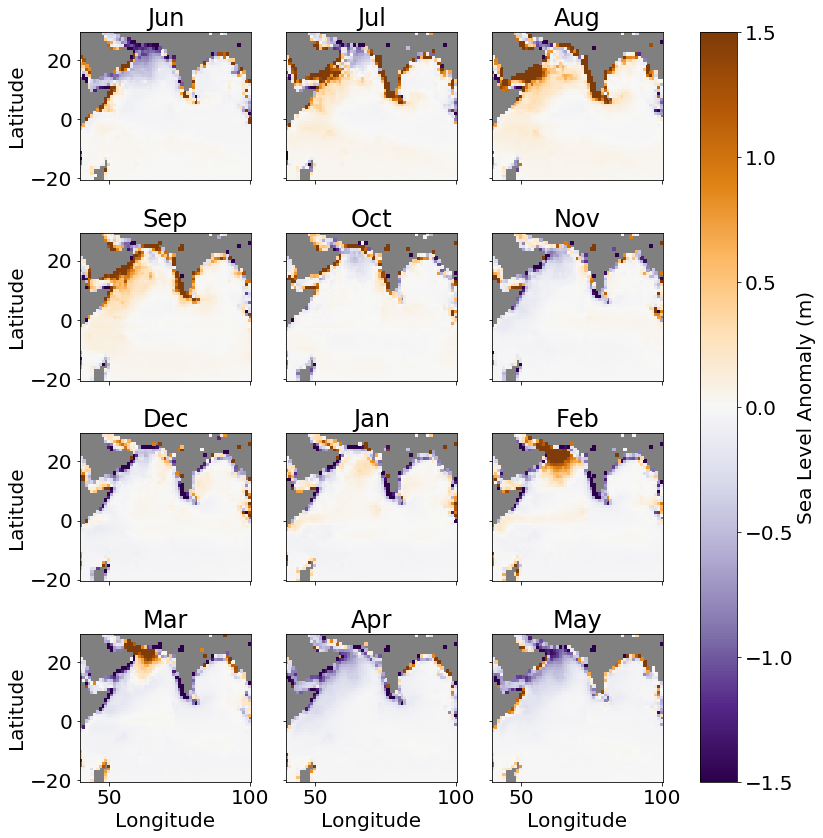

In [42]:
months = ['Jun','Jul','Aug','Sep','Oct','Nov','Dec','Jan','Feb','Mar','Apr','May']

p = rolled_ann_cyc.plot.pcolormesh(x="lon_1deg", y="lat_1deg", col="month", col_wrap=3,
                                        cmap="PuOr_r",
                                        vmax=1.5,vmin=-1.5, # set colorbar lims
                                        extend = 'neither', # make a box colorbar rather than pointed
                                        figsize = (12, 12),
                                        cbar_kwargs={"label": "Sea Level Anomaly (m)"},
                                        subplot_kws={'facecolor': 'gray'}
                                       )

for i, ax in enumerate(p.axes.flat):
    ax.set_title(months[i])
    ax.axes.axis('tight')
#     plt.subplots_adjust(top=.9)

p.set_xlabels('Longitude')
p.set_ylabels('Latitude')
# plt.savefig('../figures/annual-cycle-SLA.png', dpi=300, bbox_inches='tight')

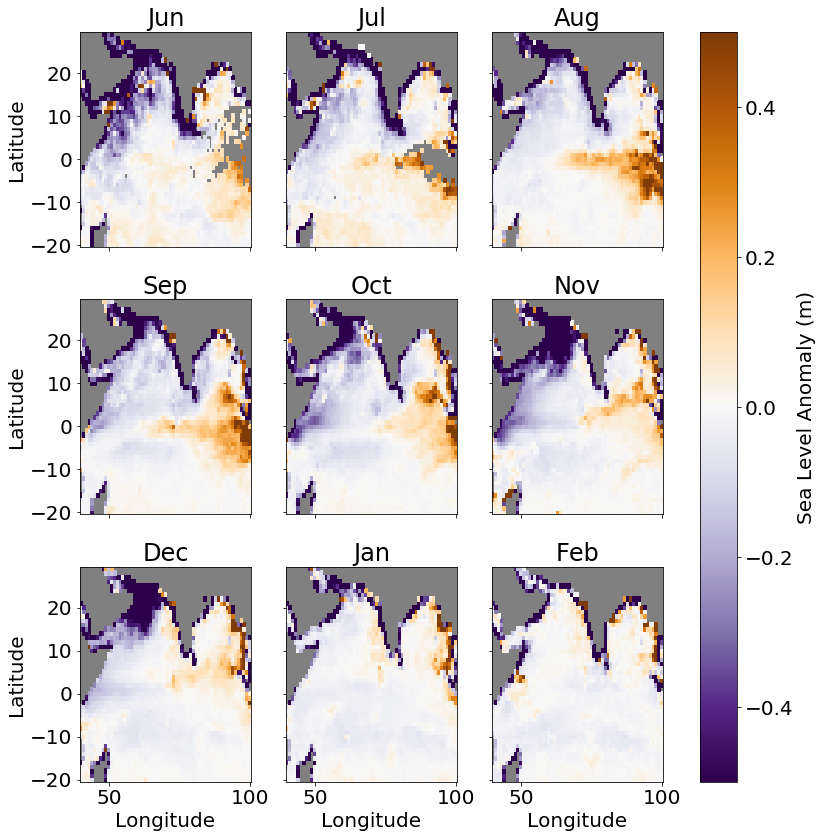

In [53]:
# posIOD
months = ['Jun','Jul','Aug','Sep','Oct','Nov','Dec','Jan','Feb','Mar','Apr','May']

p = posIOD_mon_chl_mon_anom.plot.pcolormesh(x="lon_1deg", y="lat_1deg", col="month", col_wrap=3,
                                        cmap="PuOr_r",
                                        vmax=0.5,vmin=-0.5, # set colorbar lims
                                        extend = 'neither', # make a box colorbar rather than pointed
                                        figsize = (12, 12),
                                        cbar_kwargs={"label": "Sea Level Anomaly (m)"},
                                        subplot_kws={'facecolor': 'gray'}
                                       )

for i, ax in enumerate(p.axes.flat):
    ax.set_title(months[i])
    ax.axes.axis('tight')
#     plt.subplots_adjust(top=.9)

p.set_xlabels('Longitude')
p.set_ylabels('Latitude')

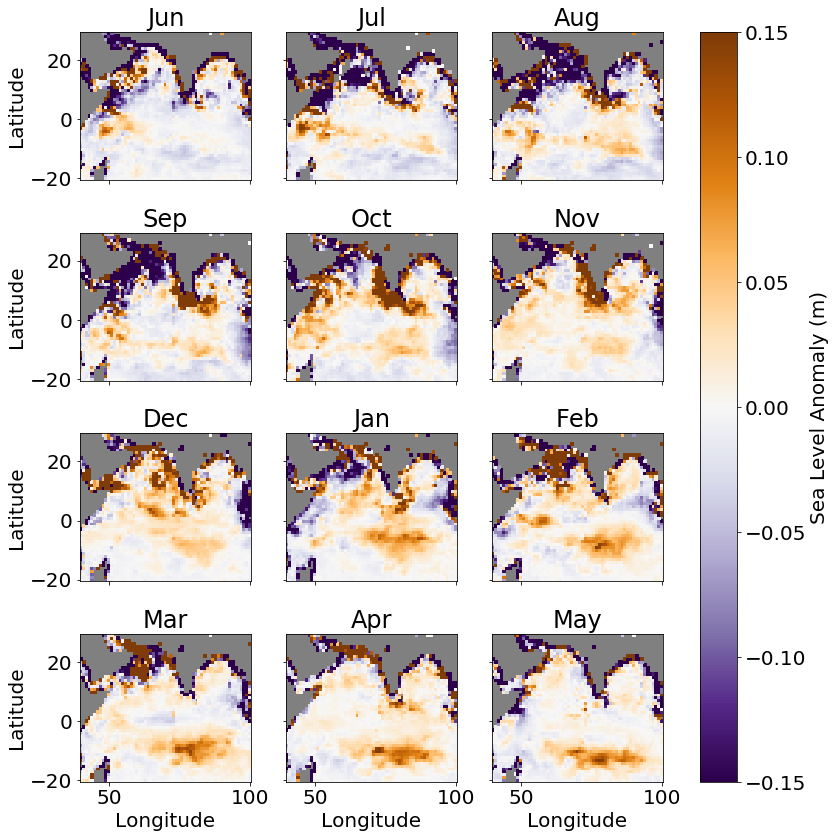

In [48]:
# negIOD
months = ['Jun','Jul','Aug','Sep','Oct','Nov','Dec','Jan','Feb','Mar','Apr','May',]

p = negIOD_mon_chl_mon_anom.plot.pcolormesh(x="lon_1deg", y="lat_1deg", col="month", col_wrap=3,
                                        cmap="PuOr_r",
                                        vmax=0.5,vmin=-0.15, # set colorbar lims
                                        extend = 'neither', # make a box colorbar rather than pointed
                                        figsize = (12, 12),
                                        cbar_kwargs={"label": "Sea Level Anomaly (m)"},
                                        subplot_kws={'facecolor': 'gray'}
                                       )

for i, ax in enumerate(p.axes.flat):
    ax.set_title(months[i])
    ax.axes.axis('tight')
#     plt.subplots_adjust(top=.9)

p.set_xlabels('Longitude')
p.set_ylabels('Latitude')

In [ ]:
# neuIOD
months = ['Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec','Jan','Feb']

p = neuIOD_mon_sla_mon_anom_dtrnd.plot.pcolormesh(x="longitude", y="latitude", col="month", col_wrap=3,
                                        cmap="PuOr_r",
                                        vmax=0.15,vmin=-0.15, # set colorbar lims
                                        extend = 'neither', # make a box colorbar rather than pointed
                                        figsize = (12, 12),
                                        cbar_kwargs={"label": "Sea Level Anomaly (m)"},
                                        subplot_kws={'facecolor': 'gray'}
                                       )

for i, ax in enumerate(p.axes.flat):
    ax.set_title(months[i])
    ax.axes.axis('tight')
#     plt.subplots_adjust(top=.9)

p.set_xlabels('Longitude')
p.set_ylabels('Latitude')

# Differences between annual cycle and positive IOD years

In [ ]:
# posIOD

var = np.sign(posIOD_mon_sla_mon_anom_dtrnd) + np.sign(rolled_ann_cyc)
months = ['Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec','Jan','Feb']

p = var.plot.pcolormesh(x="longitude", y="latitude", col="month", col_wrap=3,
                                        cmap="PuOr_r",
                                        add_colorbar=False,
                                        vmax=1,vmin=-1, # set colorbar lims
                                        extend = 'neither', # make a box colorbar rather than pointed
                                        figsize = (12, 12),
#                                         cbar_kwargs={"label": "Sea Level Anomaly (m)"},
                                        subplot_kws={'facecolor': 'gray'}
                                       )

for i, ax in enumerate(p.axes.flat):
    ax.set_title(months[i])
    ax.axes.axis('tight')

p.set_xlabels('Longitude')
p.set_ylabels('Latitude')

cmap=plt.cm.PuOr

custom_lines = [Line2D([0], [0], color=cmap(0.), lw=4),
                Line2D([0], [0], color=cmap(.5), lw=4),
                Line2D([0], [0], color=cmap(1.), lw=4)]

# ax.legend(custom_lines, ['Posititve', 'Opposite', 'Negative'],bbox_to_anchor=(-.7, -0.5), loc='center',
#          ncol = 3,handlelength=5, borderpad=1.2, labelspacing=1.2)
leg = ax.legend(custom_lines, ['Posititve', 'Opposite', 'Negative'],loc='center',
          bbox_to_anchor = (0.02,-0.55,1,1),bbox_transform = plt.gcf().transFigure,
          ncol = 3,handlelength=5, borderpad=1.2, labelspacing=1.2)
frame = leg.get_frame()
frame.set_facecolor('lightgray')

In [ ]:
# negIOD

var = np.sign(negIOD_mon_sla_mon_anom_dtrnd) + np.sign(rolled_ann_cyc)
months = ['Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec','Jan','Feb']

p = var.plot.pcolormesh(x="longitude", y="latitude", col="month", col_wrap=3,
                                        cmap="PuOr_r",
                                        add_colorbar=False,
                                        vmax=1,vmin=-1, # set colorbar lims
                                        extend = 'neither', # make a box colorbar rather than pointed
                                        figsize = (12, 12),
#                                         cbar_kwargs={"label": "Sea Level Anomaly (m)"},
                                        subplot_kws={'facecolor': 'gray'}
                                       )

for i, ax in enumerate(p.axes.flat):
    ax.set_title(months[i])
    ax.axes.axis('tight')

p.set_xlabels('Longitude')
p.set_ylabels('Latitude')

cmap=plt.cm.PuOr

custom_lines = [Line2D([0], [0], color=cmap(0.), lw=4),
                Line2D([0], [0], color=cmap(.5), lw=4),
                Line2D([0], [0], color=cmap(1.), lw=4)]

# ax.legend(custom_lines, ['Posititve', 'Opposite', 'Negative'],bbox_to_anchor=(-.7, -0.5), loc='center',
#          ncol = 3,handlelength=5, borderpad=1.2, labelspacing=1.2)
leg = ax.legend(custom_lines, ['Posititve', 'Opposite', 'Negative'],loc='center',
          bbox_to_anchor = (0.02,-0.55,1,1),bbox_transform = plt.gcf().transFigure,
          ncol = 3,handlelength=5, borderpad=1.2, labelspacing=1.2)
frame = leg.get_frame()
frame.set_facecolor('lightgray')

In [ ]:
# manually remove some points

# remove lower boundary (about 10N)
loninds = loninds[latinds>120]
latinds = latinds[latinds>120]

BoB_latinds = latinds
BoB_loninds = loninds

BoB_latinds = BoB_latinds[(BoB_loninds>195) & (BoB_loninds<276)]
BoB_loninds = BoB_loninds[(BoB_loninds>195) & (BoB_loninds<276)]
    
AS_latinds = latinds
AS_loninds = loninds

AS_latinds = AS_latinds[(AS_loninds>119) & (AS_loninds<195)]
AS_loninds = AS_loninds[(AS_loninds>119) & (AS_loninds<195)]

# EQ_latinds
# EQ_loninds

In [ ]:
#BoB

BoB_sta_zero = (274,121) # 98.625, 10.375
BoB_sta_lonind, BoB_sta_latind =order_coast_BoB(BoB_loninds,BoB_latinds,BoB_sta_zero)

In [ ]:
#AS
# take first piece
AS_sta_zero = (184,121) # 76.125, 10.375
AS_sta_lonind, AS_sta_latind =order_coast_AS(AS_loninds,AS_latinds,AS_sta_zero)
AS_sta_lonind = AS_sta_lonind[:-8]
AS_sta_latind = AS_sta_latind[:-8]

In [ ]:
# get data from tigress
path = '/home/jennap/projects/LRGROUP/shared_data/IOD_index/'
infn = 'dmi_updated_10_07_2020.nc'

dmi_ds = xr.open_dataset(path + infn)

https://agupubs.onlinelibrary.wiley.com/doi/pdf/10.1029/2007JD009151
http://www.bom.gov.au/climate/iod/

In [ ]:
var = sla_mon_clim_mon

# average over the positive IOD years
data = []
for ii,year in enumerate(posIODyears):
    start_time = year +'-01-01'
    end_time = year+'-12-31'
    time_slice = slice(start_time, end_time)
    data.append(var.sel(time=time_slice))
combined = xr.concat(data, dim='time')
posIODdata = combined.groupby('time.month').mean(dim='time')


# average over the negative IOD years
data = []
for ii,year in enumerate(negIODyears):
    start_time = year +'-01-01'
    end_time = year+'-12-31'
    time_slice = slice(start_time, end_time)
    data.append(var.sel(time=time_slice))
combined = xr.concat(data, dim='time')
negIODdata = combined.groupby('time.month').mean(dim='time')



# average over the neutral IOD years
data = []
for ii,year in enumerate(neuIODyears):
    start_time = year +'-01-01'
    end_time = year+'-12-31'
    time_slice = slice(start_time, end_time)
    data.append(var.sel(time=time_slice))
combined = xr.concat(data, dim='time')
neuIODdata = combined.groupby('time.month').mean(dim='time')

